In [46]:
show_plots = True

In [47]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [48]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time

In [49]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

<Figure size 432x288 with 0 Axes>

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2021, source: 

In [50]:
input_path = './../../input/'
output_path = './../../output/'
model_path = './../../model/'

## Zones

Load zone data from the input files

### read in Berliner Ortsteile shapefile

In [51]:
zones = gpd.read_file(input_path + "zones/Berliner_Ortsteile.shp")
zones = zones.to_crs(epsg=4326)
#hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull = unary_union([x.buffer(1e-3) for x in zones['geometry']])
if show_plots:
    hull

### read in Umweltzone (SBahn Ring)

In [52]:
# remove duplicate zone entry (Buch) 
from shapely.ops import unary_union
sch = zones['sch']
dpls = list(sch[sch.duplicated()])
for dpl in dpls:
    print("dpl",dpl, "len zones", len(zones))
    zones['geometry'][sch == dpl][0] = unary_union([x for x in zones['geometry'][sch == dpl]])
    blIndex = [True if (not s == dpl) or (not dpl in list(sch.iloc[:n])) else False for n, s in enumerate(sch)]
    zones = zones[blIndex]
    print("len zones", len(zones), all(blIndex))

sch = zones['sch']
if len(list(sch[sch.duplicated()])) > 0:
    print("duplicates:", list(sch[sch.duplicated()]))


dpl 110000030309 len zones 98
len zones 97 False


<AxesSubplot:>

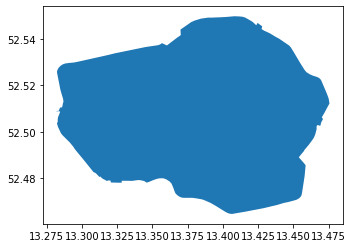

In [53]:
umweltzone = gpd.read_file(input_path + "zones/Umweltzone_-_Berlin")
umweltzone = umweltzone.to_crs(epsg=4326)
umweltzone_geom = umweltzone['geometry'].iloc[0]
umweltzone.plot()

### read and clean in building block shapefile

In [100]:
# Add building block shapefile
blocks = gpd.read_file(input_path + "zones/Einwohnerdichte_2021.shp")
blocks.to_crs(epsg=4326, inplace=True)
# remove blocks without geometry property
print("removing", sum(blocks.geometry == None), 
      "blocks with",
      round(sum(blocks[blocks.geometry == None]["ew2021"])),
      "inhabitants due to lack of geometry, e.g. block with schl5 =",
     blocks[blocks.geometry == None].iloc[0]["schl5"] if len(blocks[blocks.geometry == None])>0 else '')
blocks = blocks[blocks.geometry != None]
blocks = blocks[blocks['ew2021'] > 0]
blocks["zone"] = None

# add information whether block in umweltzone or not
blocks['umweltzone'] = [x.intersects(umweltzone['geometry'].iloc[0]) for x in blocks['geometry']]


removing 0 blocks with 0 inhabitants due to lack of geometry, e.g. block with schl5 = 


In [101]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='ew_ha_2021', cmap = "viridis", legend=True)

### assign a zone to each block (no longer necessary as zones originate from building block cluster assignment)

In [56]:
# assign zone to each block
blocks["zone"] = \
    blocks['geometry']\
        .apply(lambda g: zones.index[zones.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)


In [57]:
# if show_plots:
#     # plot
#     fig, ax = plt.subplots(figsize = (16,12))
#     sm.zones.plot(ax=ax, color="#ffffff00", edgecolor="#555")
#     blocks.plot(ax=ax, column='zone', cmap = "viridis", legend=False)
#     ax.set_title("Assignment of blocks to zones")

# cluster building blocks to zones using k_means algorithm

In [58]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    blocks.plot(ax=ax, column='umweltzone', cmap = "viridis", legend=True)

In [59]:
# create start points as grid for clustering algorithm
n_x = 30
n_y = n_x
bounds = zones.total_bounds # can also be hull.bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]
x_step = (x_max-x_min)/n_x
y_step = (y_max-y_min)/n_y
bounds
grid = [item for sublist in [[Point(x_min+x_step*(i_x+i_y%2/2), y_min+i_y*y_step, ) for i_y in range(n_y+1)] for i_x in range(n_x+1)] for item in sublist]
grid = gpd.GeoSeries(grid, crs=4326)
grid_brandenburg = grid[[not x for x in grid.within(hull)]]
grid = grid[[x for x in grid.within(hull)]]
grid_umweltzone = grid[[x for x in grid.within(umweltzone_geom)]]
grid_non_umweltzone = grid[[not x for x in grid.within(umweltzone_geom)]]
grid = grid[grid.within(hull)]
grid.index = range(len(grid))

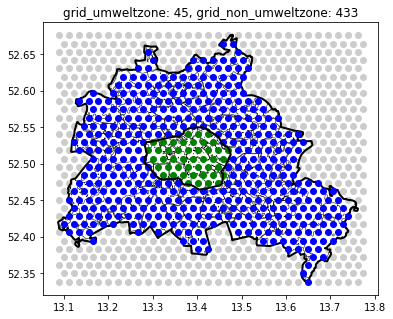

In [78]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    grid_brandenburg.plot(ax=ax, color="#cccccc")
    gpd.GeoSeries(hull, crs=4326).plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    zones.plot(ax=ax, color="None", edgecolor="black", linewidth=0.5)
    grid_umweltzone.plot(ax=ax, color="green")
    grid_non_umweltzone.plot(ax=ax, color="blue")
    umweltzone.plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    ax.set_title("grid_umweltzone: " + str(len(grid_umweltzone)) + ', grid_non_umweltzone: ' + str(len(grid_non_umweltzone)))

## create zone geometries starting from building block cluster assignment

In [86]:
import time
t = time.time()

show_plots_here = show_plots and True
if show_plots_here:
    zones_geoms_at_iteration = [blocks]

# gradually increase a buffer around polygons to match the area not covered by buildings to zones
# choose starting buff_param and buff_increase as small as feasible to increase precision.

# if this method is too slow one could implement grid search.

buff_param, buff_increase, only_polygons, clean_geoms, ease_boders = 0.0005, 0.0005, False, False, False

# To-Do data on this shoul be already available from cluster algorithm
zones['umweltzone'] = [list(blocks['umweltzone'][blocks['zone'] == i])[0] for i in zones.index] 

# divide into outside umweltzone and inside umweltzone
zone_free_area = [MultiPolygon([hull.difference(umweltzone_geom)]), MultiPolygon([umweltzone_geom])]

# save a copy of intial geometry to apply buffer. As applying buffer to geom with buffer increases the complexity.
initial_zone_geoms = [unary_union(list(blocks['geometry'][blocks['zone'] == i])).buffer(buff_param) for i in zones.index]
zones['geometry'] = initial_zone_geoms
# stop only when all area has been devided among zones
islands = []
it=0
while not all([x.is_empty for x in zone_free_area]):
    print(buff_param, len(islands), 'of', len(zones), 'complexity zones:', 
    sum([sum([len(z.exterior.coords) + sum([len(y.coords) for y in z.interiors]) for z in x]) if type(x) == MultiPolygon else (len(x.exterior.coords) + sum([len(y.coords) for y in x.interiors]) ) for n, x in enumerate(zones['geometry']) if n not in islands]),    
    '(', sum([len(x) if type(x) == MultiPolygon else 1 for n, x in enumerate(zones['geometry']) if n not in islands]),')',
    'complexity zone free area:', 
    sum([sum([len(z.exterior.coords) + sum([len(y.coords) for y in z.interiors]) for z in x]) for x in zone_free_area]),
    '(', sum([len(x) for x in zone_free_area]),')',
    'time:', round(time.time()-t,2))
    t = time.time()


    for n, zone_geom, inital_zone_geom, umweltzone_bool in zip(zones.index, zones['geometry'], initial_zone_geoms, zones['umweltzone']):
        if n in islands:#zone_free_area[umweltzone_bool].is_empty
            continue
        
        geo_dict = {
            'index': [n for n,x in enumerate(zone_free_area[umweltzone_bool]) if x.intersects(zone_geom)], 
            'intsctns':[], 
            'diffs': []
            }
        
        # if that zone did at one point not touch neutral area it means that its fully surrounded by other areas assigned to zones
        # thus one can jump to next
        if len(geo_dict['index'])==0:
            islands.append(n)
            continue

        buffed_zone = \
            unary_union([x.buffer(buff_param) for x in inital_zone_geom])\
            if type(inital_zone_geom) == MultiPolygon else \
            inital_zone_geom.buffer(buff_param)
        
        # only assign are that has been touching to zones to prevent
        for i_neutral in list(geo_dict['index']):
            intsctn = buffed_zone.intersection(zone_free_area[umweltzone_bool][i_neutral])
            geo_dict['intsctns'].append(intsctn)
            # if not intsctn.is_empty:
            diff = zone_free_area[umweltzone_bool][i_neutral].difference(buffed_zone)
            geo_dict['diffs'].append(diff)
        
        zones['geometry'].iloc[n] = unary_union([zone_geom]+geo_dict['intsctns'])
        
        zone_free_area[umweltzone_bool] = \
            unary_union(\
                [geo_dict['diffs'][geo_dict['index'].index(i)] \
                if i in geo_dict['index'] else poly \
                for i, poly in enumerate(zone_free_area[umweltzone_bool])])
        if not type(zone_free_area[umweltzone_bool]) == MultiPolygon:
            zone_free_area[umweltzone_bool] = MultiPolygon([zone_free_area[umweltzone_bool]])
    
    buff_param += buff_increase
    it+=1
    if show_plots_here:
        zones_geoms_at_iteration.append(zones.copy())

# clean geometries: just take polygons (no multipolygons)
zones['geometry'] = [x.intersection(hull) for x in zones['geometry']]

if only_polygons:
    zones['geometry'] = [max(x, key=lambda a: a.area) if type(x) == MultiPolygon else x for x in zones['geometry']]

if clean_geoms:
    zones['geometry'] = [x.difference(unary_union(list(zones['geometry'][:n]))) for n, x in enumerate(zones['geometry'])]

if ease_boders:
    0# not implemented yet.

print("done.")

0.0005 0 of 97 complexity zones: 164925 ( 288 ) complexity zone free area: 12734 ( 2 ) time: 8.8
0.001 0 of 97 complexity zones: 183193 ( 226 ) complexity zone free area: 129404 ( 940 ) time: 40.19
0.0015 0 of 97 complexity zones: 154043 ( 210 ) complexity zone free area: 77449 ( 302 ) time: 61.49
0.002 1 of 97 complexity zones: 141674 ( 196 ) complexity zone free area: 54577 ( 225 ) time: 43.42
0.0025 2 of 97 complexity zones: 136173 ( 197 ) complexity zone free area: 41502 ( 138 ) time: 21.83
0.003 11 of 97 complexity zones: 123110 ( 156 ) complexity zone free area: 33217 ( 120 ) time: 15.38
0.0035 15 of 97 complexity zones: 115717 ( 145 ) complexity zone free area: 27268 ( 97 ) time: 11.67
0.004 16 of 97 complexity zones: 113752 ( 139 ) complexity zone free area: 22875 ( 77 ) time: 8.71
0.0045000000000000005 25 of 97 complexity zones: 100230 ( 121 ) complexity zone free area: 19744 ( 65 ) time: 5.77
0.005000000000000001 27 of 97 complexity zones: 97170 ( 119 ) complexity zone free a

TypeError: can only concatenate list (not "int") to list

In [95]:
math.ceil(math.sqrt(12))

4

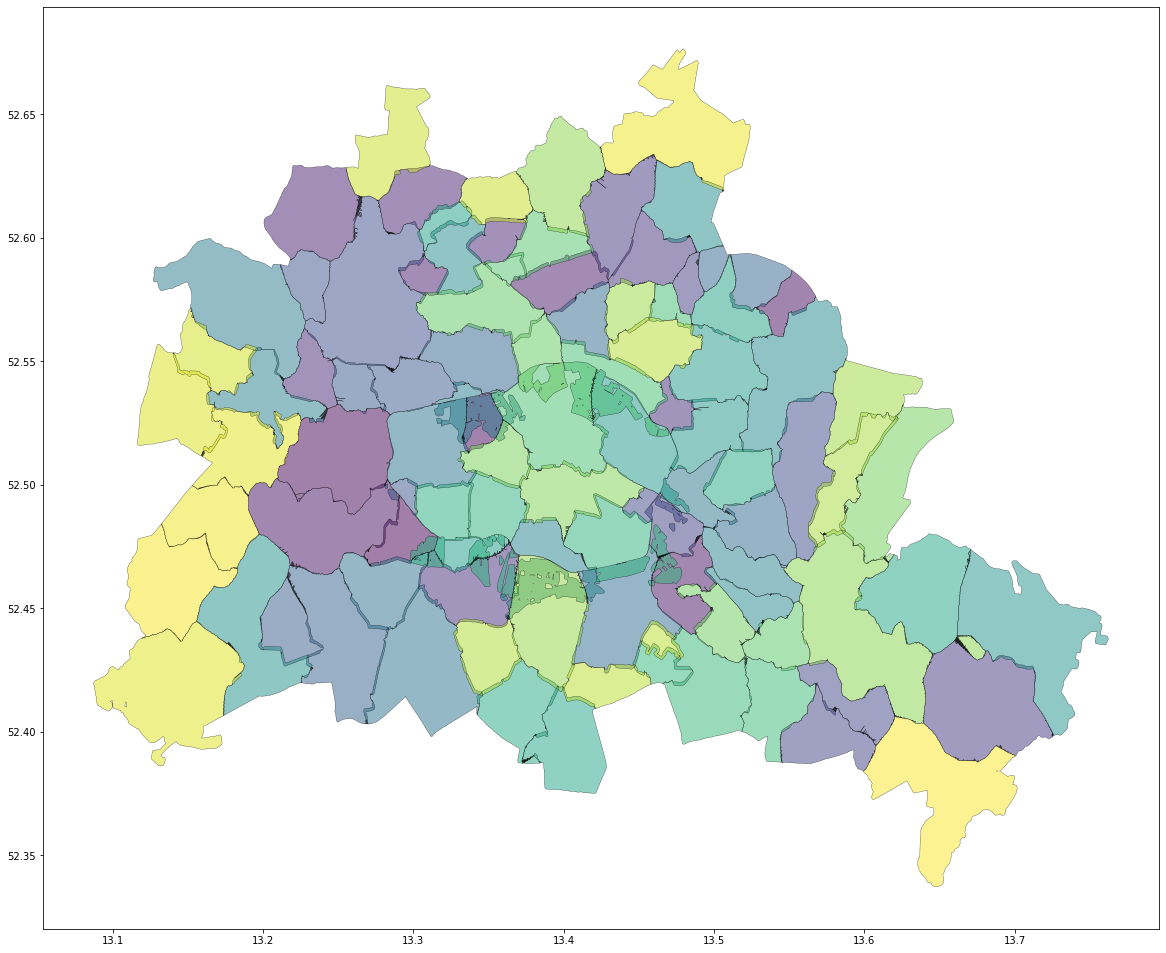

In [91]:
import math
if show_plots_here:
    fig, ax = plt.subplots(nrows=math.ceil(math.sqrt(len(zones_geoms_at_iteration)+1)), ncols=math.floor(math.sqrt(len(zones_geoms_at_iteration)+1)), figsize = (20,45))
    for n, a in enumerate(ax.flat):
        if n >= len(zones_geoms_at_iteration):
            fig.delaxes(a) ## delete if nothing is plotted in the axes obj
            continue        

        a.set_title('Iteration: ' + str(n))
        if n == 0:
            zones_geoms_at_iteration[n].plot(ax=ax.flat[0], color = "green", alpha=0.2)
        else:
            gpd.GeoSeries(hull, crs=4326).plot(ax=a, color="None", edgecolor="black", linewidth=2)
            zones_geoms_at_iteration[n].plot(ax=a, cmap = "viridis", alpha=0.5)
            zones_geoms_at_iteration[n].plot(ax=a, color = "None", edgecolor="black", linewidth=0.25)
            umweltzone.plot(ax=a, color="None", edgecolor="black", linewidth=2)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,20))
    zones.plot(ax=ax, cmap = "viridis", alpha=0.5)
    zones.plot(ax=ax, color = "None", edgecolor="black", linewidth=0.25)

In [ ]:
zones['geometry'] = [x.intersection(hull) for x in zones['geometry']]


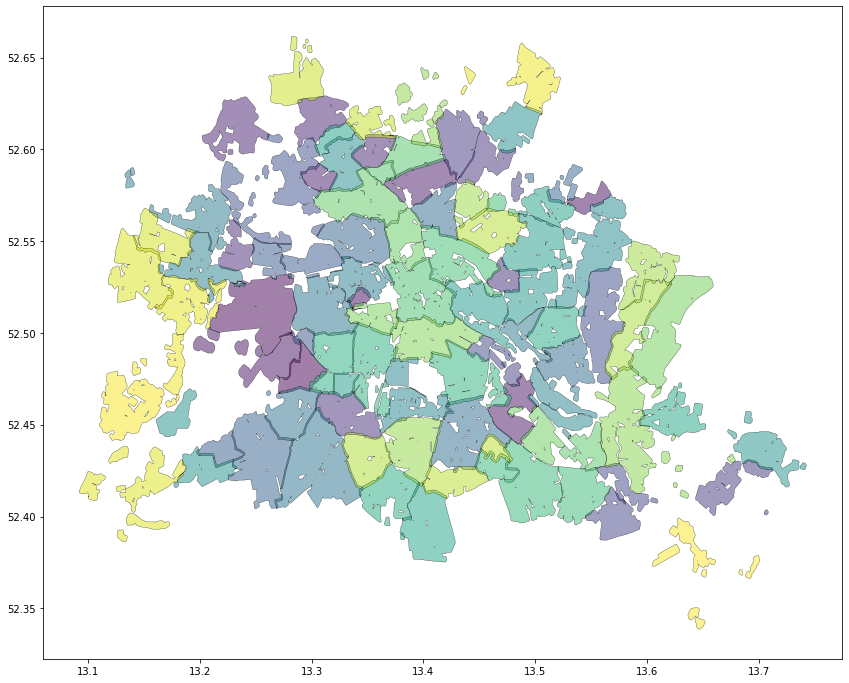

In [76]:
if show_plots:
    fig, ax = plt.subplots(figsize = (16,12))
    # zones.plot(ax=ax, column='umweltzone', cmap = "viridis", alpha=0.5)
    zones.plot(ax=ax, cmap = "viridis", alpha=0.5)
    # blocks.plot(ax=ax, color = "green", alpha=0.2)
    zones.plot(ax=ax, color = "None", edgecolor="black", linewidth=0.25)
    # umweltzone.plot(ax=ax, color="None", edgecolor="black", linewidth=2)
    # sm.zones.plot(ax=ax, color="None", edgecolor="red", linewidth=0.25)

In [600]:
zone_free_area[umweltzone_bool]

In [453]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
# Save zones into the model
sm.zones = zones
if show_plots: sm.zones.plot()
sm.zones.sample(2)

uuid           sch              nam           gdf  \
57  DEBE09YYO000000B  110000090911  Friedrichshagen  1.403386e+07   
75  DEBE00YY2Ke00071  110000101004        Mahlsdorf  1.301659e+07   

                bezeich                                           geometry  
57  AX_KommunalesGebiet  POLYGON ((13.66151 52.47405, 13.66265 52.47376...  
75  AX_KommunalesGebiet  POLYGON ((13.63456 52.53048, 13.63468 52.53048...

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:17. Minutes remaining: 00:00. 

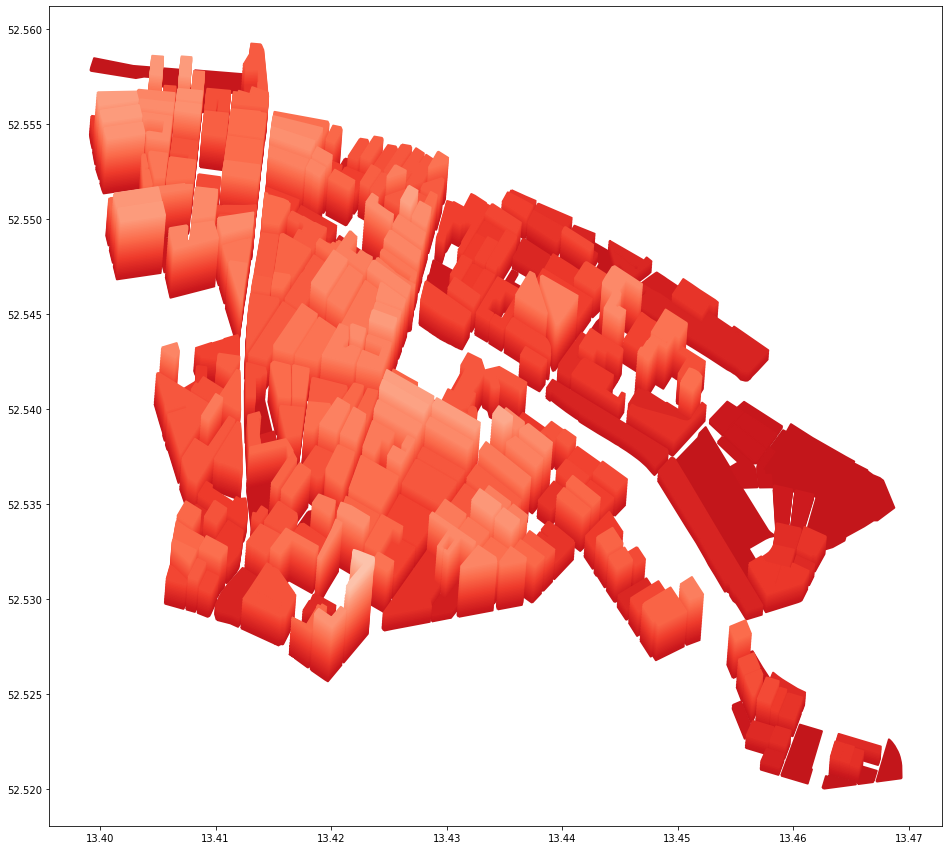

In [690]:
if show_plots:
    # some map art

    from shapely.affinity import translate
    from shapely.ops import unary_union
    import time
    # sf = ["Prenzlauer Berg"]#["Pankow", "Prenzlauer Berg", "Mitte"]
    # spb = blocks[blocks["zone"].isin(sm.zones.index[sm.zones["nam"].isin(sf)])]
    
    spb = blocks[blocks["zone"].isin([sm.zones.index[67]])]
    bspb = unary_union(list(spb.geometry.apply(lambda g: g.buffer(0.002))))
    bspb = Polygon(bspb.exterior.coords)

    fig, ax = plt.subplots(figsize = (16,16))
    t0 = time.time()

    # sm.road_links.geometry[list(sm.road_links.intersects(bspb))].apply(lambda g: g.buffer(0.00022).intersection(bspb)).plot(ax=ax, color ="grey")


    maxHeight = max(spb["ew_ha_2021"])

    nSteps = 50
    cbuff = 40
    cmap = plt.get_cmap('Reds_r', nSteps + cbuff)

    for i in range(0,nSteps):
        # spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2021"] >= i/nSteps*maxHeight) else None, axis = 1)
        spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 0.00001,0.00008) if (row["ew_ha_2021"] >= i/nSteps*maxHeight) else None, axis = 1)
        spb.plot(ax=ax, color = cmap(round(i + 0.5*cbuff)), edgecolor = cmap(round(i + 0.5*cbuff)), linewidth = 2)
        # spb.plot(ax=ax, column='ew_ha_2021', cmap = "viridis", linewidth = 2)
        helpers.printProgress(i=i, imax=nSteps, t=time.time(), t0=t0)



### for each zone: sum up population from blocks and create centroids weighted by population

In [460]:
t0=time.time()
# sum up population from blocks to each zone and create centroids weighted by population
sm.zones["pop"] = 0
sm.zones["popCentroid"] = Point(0.0,0.0)
sm.zones["popCentroidOffset"] = LineString([Point(0.0,0.0), Point(0.0,0.0)])
sm.zones["popCentroidLat"] = 0.0
sm.zones["popCentroidLon"] = 0.0

for zoneIndex, zone in sm.zones.iterrows():
    blocksInZone = blocks[blocks["zone"]==zoneIndex]
    
    # obtain total zone population and save to sm.zones
    zonePopulation2021 = sum(blocksInZone["ew2021"])
    sm.zones.at[zoneIndex, "pop"] = zonePopulation2021
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for blockIndex, block in blocksInZone.iterrows():
        weigthedCoords["lon"] += block["ew2021"] / zonePopulation2021 * block["geometry"].centroid.x
        weigthedCoords["lat"] += block["ew2021"] / zonePopulation2021 * block["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone["nam"])
        blocksInZone.plot()
    
    sm.zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    sm.zones.loc[zoneIndex, "popCentroidOffset"] = LineString([zone["geometry"].centroid, popCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

popCentroid (13.228250106615496, 52.580581987471035) not within polygon for zone 24 Konradshöhe


Text(0.5, 1.0, 'Zones centroids vs population weigthed centroids')

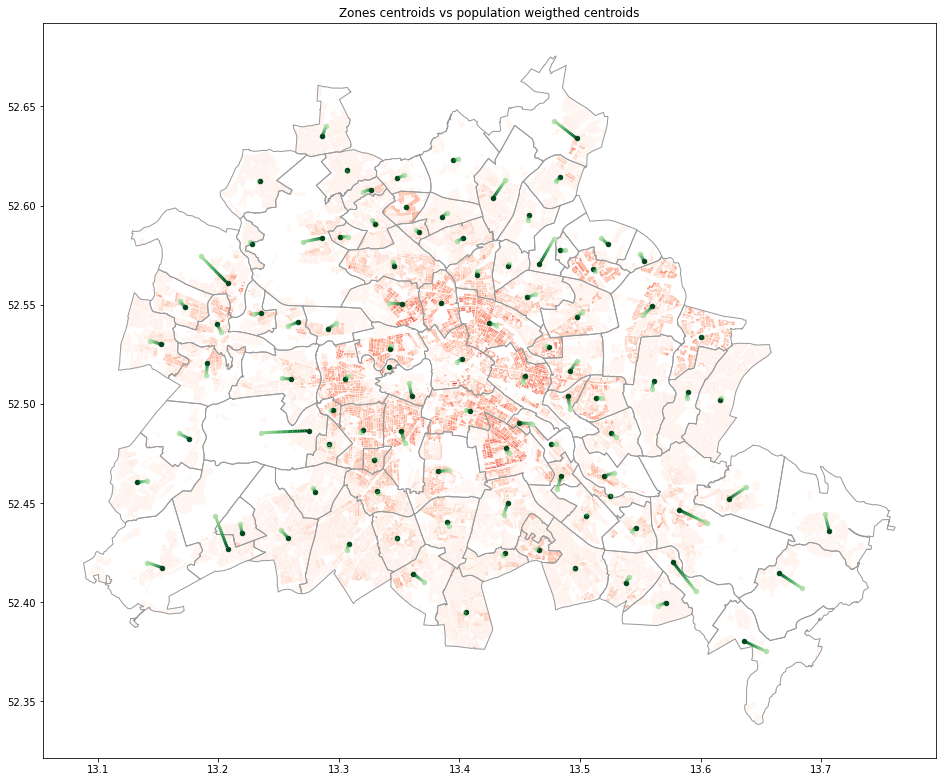

In [461]:
if show_plots:
    # show zones and popCentroids and their offsets from real geometrical centroids
    fig, ax = plt.subplots(1, 1, figsize=(16,16))
    blocks.plot(ax=ax, column='ew_ha_2021', cmap = "Reds")
    # add zone borders and a bit of opacity
    sm.zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
    nSteps = 20
    cbuff = 10
    cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
    gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
    for i in range(1,nSteps):
        l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.popCentroidOffset]
        gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
    gpd.GeoSeries(sm.zones.popCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
    ax.set_title("Zones centroids vs population weigthed centroids")

<AxesSubplot:>

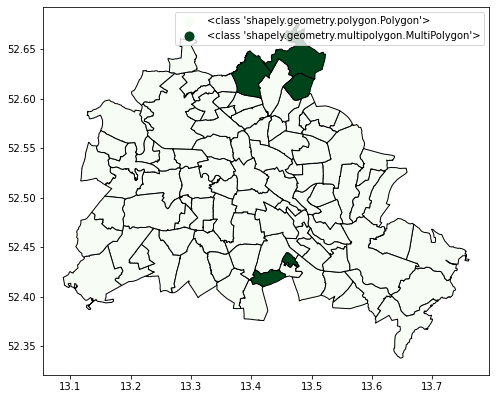

In [462]:
if show_plots:
    # plot zones by geometry type
    sm.zones.plot(column = np.array([type(x) for x in sm.zones["geometry"]]),  cmap = "Greens",  edgecolor="black", legend=True, figsize = (8,8))

# Add zone statistics weighted by population or block square meters


## Add employment data (based on data for planungsraeume and bezirke)

In [463]:
blocks.head(2)

schl5  ew2020  flalle  ew_ha_2020  \
0  0100980011000100     3.0  4624.0    6.487889   
1  0100980011000300    21.0  5604.0   37.473233   

                                             typklar    area_calc  \
0  Freie Zeilenbebauung mit landschaftlichem Sied...  4623.945832   
1    Geschosswohnungsbau der 1990er Jahre und jünger  5603.674449   

                                            geometry  zone  
0  POLYGON ((13.36830 52.53464, 13.36857 52.53475...  68.0  
1  POLYGON ((13.36732 52.53556, 13.36693 52.53592...  68.0

In [483]:
if show_plots:
    plr = gpd.read_file(input_path + "zones/lor_planungsraeume")
    plr.to_crs(epsg=sm.epsg, inplace=True)
    plr.plot(cmap="viridis")
    plr.set_index(plr['broker Dow'], inplace=True)
    plr.head()

BEZIRKSNAM                PLANUNGSRA  DATUM_GUEL  FLAECHENGR  \
broker Dow                                                                
01011101        Mitte              Stülerstraße  14.06.2006   366755.50   
01011102        Mitte         Großer Tiergarten  14.06.2006  3009397.45   
01011103        Mitte              Lützowstraße  14.06.2006   522356.58   
01011104        Mitte              Körnerstraße  14.06.2006   338383.45   
01011105        Mitte  Nördlicher Landwehrkanal  14.06.2006   934609.72   

           broker Dow                                           geometry  
broker Dow                                                                
01011101     01011101  POLYGON ((13.33889 52.50542, 13.33986 52.50562...  
01011102     01011102  POLYGON ((13.33140 52.51288, 13.33141 52.51285...  
01011103     01011103  POLYGON ((13.34923 52.50307, 13.34972 52.50343...  
01011104     01011104  POLYGON ((13.36254 52.49966, 13.36265 52.49989...  
01011105     01011105  POLYGON ((13.35159 52.50976, 13.35199 52.50978...

In [465]:
# read in employment data and create best guess for each plr employment
# only number of Niederlassungen per plr per Beschäftiungsgrößenklassen is given
employment = pd.read_excel(input_path + 'unternehmen_plr.xlsx')

plr['Bezirk'] = [employment['Bezirk'][employment['broker Dow'] == int(p)].iloc[0] for p in plr['broker Dow']]

# create guess for total employment per plr: 2/3 lower bound + 1/3 upper bound
employment['guess'] = \
    employment['0 bis unter 10'] * (0*2+10*1)/3 + \
    employment['10 bis unter 50'] * (10*2+50*1)/3 + \
    employment['50 bis unter 250'] * (50*2+250*1)/3 + \
    employment['250 und mehr'] * (250*2+300*1)/3

# create bezirke gdf based on information of employment data
bezirke = gpd.GeoDataFrame(
    {'Bezirk': employment['Bezirk'].unique()}, 
    geometry=[unary_union([x.buffer(0.0001) for x in plr['geometry'][plr['Bezirk']==b]]) for b in plr['Bezirk'].unique()], 
    crs=sm.epsg
    )
bezirke['guess_sum'] = [sum(employment['guess'][employment['Bezirk']==b]) for b in bezirke['Bezirk']]
bezirke['real_employment'] = [employment['Beschaeftige Bezirk'][employment['Bezirk']==b].iloc[0] for b in bezirke['Bezirk']]
bezirke['correction_factor'] = bezirke['real_employment'] / bezirke['guess_sum']
print('correction_factor', [round(x,2) for x in bezirke['correction_factor']])

# apply correction factor to guess
employment['corrected_guess'] = employment.apply(lambda row: (row['guess'] * bezirke['correction_factor'][bezirke['Bezirk'] == row['Bezirk']]).iloc[0], axis=1)
# employment = gpd.GeoDataFrame(employment, geometry=

correction_factor [1.23, 0.94, 0.83, 0.86, 1.06, 0.87, 0.91, 0.76, 0.88, 0.91, 0.88, 0.97]


In [466]:
# assign zone to each block
blocks["plr"] = \
    blocks['geometry']\
        .apply(lambda g: plr.index[plr.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)

# sum total are of blocks within plr
plr['block_area_calc'] = [sum(blocks['area_calc'][blocks['plr']==i]) for i in plr.index]

# calculate share of each block area in plr area 
blocks['plr_share'] = [a/plr['block_area_calc'][plr.index==p][0] if not p==None else 0 for p,a in zip(blocks['plr'], blocks['area_calc'])]
print("should be all around 1:", min([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index]), max([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index]))
print("plr not included:", [x for x in plr.index if x not in list(blocks['plr'])])

should be all around 1: 0.9999999999999989 1.0000000000000007
plr not included: []


In [467]:
# now obtain employment guess for each block 
blocks['plr_employment'] = [employment['corrected_guess'][employment['broker Dow']==int(p)].iloc[0] if not p==None else 0 for p in blocks['plr']]
blocks['employment'] = blocks['plr_employment'] * blocks['plr_share']

# now sum data from building block level to zone level
sm.zones['emp'] = [sum(blocks['employment'][blocks['zone']==i]) for i in sm.zones.index]


In [468]:
if show_plots:
    # this plot should be adapted to show the process. it could show the following:
    # employment data by district (Bezirk)
    # guess based on companies for plr
    # corrected guess for plr
    # employment per building 
    # employment per zone

    fig, ax = plt.subplots(3, 2, figsize=(16,24))
    bezirke.plot(ax=ax.flat[0], column='real_employment', cmap="Reds", legend=True, edgecolor="black", linewidth=1)
    bezirke.plot(ax=ax.flat[1], column='guess_sum', cmap="Reds", legend=True, edgecolor="black", linewidth=1)
    blocks.plot(ax=ax.flat[2], column='plr_employment', cmap="Reds", legend=True)
    blocks.plot(ax=ax.flat[3], column='employment', cmap="Reds", legend=True)
    blocks.plot(ax=ax.flat[4], column='plr_share', cmap="Reds", legend=True)
    sm.zones.plot(ax=ax.flat[5], column='emp', cmap="Reds", legend=True, edgecolor="black", linewidth=1)
    plr.plot(ax=ax.flat[0], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[1], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[2], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[3], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[4], color='None', edgecolor="black", linewidth=0.15)
    plr.plot(ax=ax.flat[5], color='None', edgecolor="black", linewidth=0.15)
    ax.flat[0].set_title("real_employment per district")
    ax.flat[1].set_title("uncorrected guess per district")
    ax.flat[2].set_title("employment per plr")
    ax.flat[3].set_title("employment per block")
    ax.flat[4].set_title("plr_share per block")
    ax.flat[5].set_title("employment per zone")

Text(0.5, 1.0, 'employment per zone')

In [ ]:
## Add demographic information (based on data on postcal code level)

### Next steps. Create attractor estimation.

Create attractor fields. <br>
Use school locations. (shapefile already there) <br>
Use Business locations (look up via OSM) <br>
Use Shopping locations (look up via OSM) <br>
Maybe use other data source like traffic data? <br>
Maybe use block height? <br>
Get Data on Mode Choice / Car Ownership for each zone? <br>

## Save model

In [470]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
sm.zones = sm.zones.drop(columns = [x for x in ['popCentroid', 'popCentroidOffset'] if x in sm.zones.columns])

In [473]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|██████████| 32/32 [00:01<00:00, 21.42it/s]
